# Spin glass optimization


Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/spin_glass.ipynb)

# Spin glasses and the Sherrington-Kirkpatrick model

The Sherrington-Kirkpatrick (SK) model is a model of a spin glass, a system of spins that are coupled to each other. The spins are Ising spins, which can be either up or down, and the coupling between spins is given by a matrix $J_{ij}$. The Hamiltonian of the system is given by:

$$
H = - \sum_{i<j} J_{ij} s_i s_j - \sum_i h_i s_i
$$

where $s_i$ is the spin of the $i$-th spin, $J_{ij}$ is the symmetric coupling between the $i$-th and $j$-th spins, and $h_i$ is the external field on the $i$-th spin. While the spins are discrete, the elements of $J_{ij}$ are continuous. In typical settings, the couplings are drawn from a Gaussian distribution with mean 0 and standard deviation $\sigma$.

### Implementing the SK model

We implement the SK model in Python. Our class `SherringtonKirkpatrickSpinGlass` will take, at initialization, the number of spins $N$, and the external fields $h_i$, the standard deviation of the Gaussian couplings $J_{ij}$, and the random number generator.

In [68]:
import numpy as np
from typing import Optional, Union, Iterable

class SherringtonKirkpatrickSpinGlass:
    """
    Sherrington-Kirkpatrick (SK) spin glass with Ising spins s_i ∈ {−1, +1}.

    Hamiltonian:
        H(s) = -sum_{i<j} J_{ij} s_i s_j - sum_i h_i s_i
             = -0.5 * s^T J s - h^T s   with J symmetric, diag(J)=0.

    Parameters
    ----------
    n : int
        Number of spins.
    h : Optional[Iterable[float]]
        External fields; defaults to zeros.
    rng : Optional[numpy.random.Generator]
        Random generator for reproducibility (default: PCG64()).
    scale : Union[str, float]
        Standard deviation of i.i.d. Gaussian couplings before symmetrization.
        "1/sqrt(n)" (default) uses σ = 1/√n (thermodynamic SK scaling).
        A float sets σ explicitly.
    """
    def __init__(
        self,
        n: int,
        h: Optional[Iterable[float]] = None,
        scale: Union[str, float] = "1/sqrt(n)",
        random_state: Optional[int] = None,
    ) -> None:
        self.n = n
        self.random_state = random_state
        self.h = np.zeros(n, dtype=float) if h is None else np.asarray(h, dtype=float)
        self.rng = np.random.default_rng(random_state)

        # choose coupling std
        if isinstance(scale, (int, float)):
            sigma = float(scale)
        elif isinstance(scale, str) and scale.strip().lower() in {"1/sqrt(n)", "1/sqrtn", "n^{-1/2}"}:
            sigma = 1.0 / np.sqrt(n)
        else:
            raise ValueError("scale must be a float or '1/sqrt(n)'.")

        # i.i.d. Gaussian, then symmetrize and zero diagonal
        J = self.rng.normal(loc=0.0, scale=sigma, size=(n, n))
        J = np.triu(J, 1)
        self.J = (J + J.T).astype(float)  # symmetric, diag=0

    def energy(self, s: Iterable[int]) -> float:
        """Return H(s) for spins s ∈ {−1,+1}^n."""
        return float(-0.5 * s @ (self.J @ s) - self.h @ s)

    def random_spins(self) -> np.ndarray:
        """Sample a random spin configuration s ∈ {−1,+1}^n."""
        return self.rng.choice(np.array([-1, 1], dtype=int), size=self.n)

    def flip_energy_delta(self, s: Iterable[int], i: int) -> float:
        """
        Energy change ΔH from flipping spin i (useful for local search/Metropolis):
            ΔH = H(s with s_i→−s_i) − H(s) = 2 s_i (h_i + (J s)_i)
        """
        return float(2.0 * s[i] * (self.h[i] + self.J[i] @ s))


Energy: 4.870518601943028


Text(0.5, 1.0, 'Coupling Matrix')

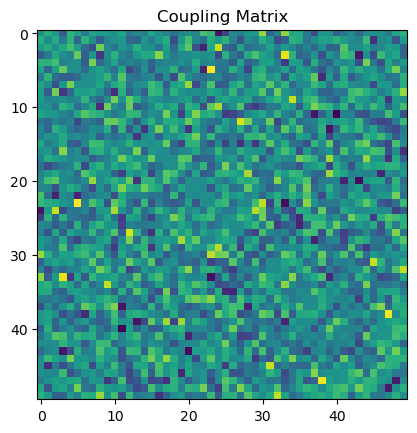

In [69]:
sk = SherringtonKirkpatrickSpinGlass(n=50, scale="1/sqrt(n)", random_state=1)
s = sk.random_spins()
print("Energy:", sk.energy(s))

plt.figure()
plt.imshow(sk.J)
plt.title("Coupling Matrix")

# Simulated annealing

**Simulated annealing (SA)** is a stochastic optimization method inspired by the process of slowly cooling a physical system into its ground state. The algorithm is as follows:

1. Start with a random configuration of spins $\mathbf{s} \in \{-1,+1\}^N$.  
2. At each step, propose a small change (flip a single spin).
3. If the change **lowers the energy**, accept it.  
4. If the change **raises the energy** by $\Delta E$, accept it with probability  
  \[
  p = e^{-\Delta E / T},
  \]
  where $T$ is an effective "temperature".  

5. Schedule: gradually reduce the temperature $T$ from a high initial value $T_0$ to a low final value $T_f$.

The idea behind simulated annealing is to balance **exploration** (avoiding poor local minima and exploring the large set of possible spin configurations) and **exploitation** (refining a candidate solution).


## Python Implementation of simulated annealing

We will implement a `SimulatedAnnealingOptimizer` class that wraps this algorithm:

- **Initialization**  
  Takes a landscape object with:
  - `.energy(s)` → compute Hamiltonian $H(\mathbf{s})$  
  - `.flip_energy_delta(s, i)` → efficient local energy update  
  - `.random_spins()` → sample a random spin configuration  

- **Optimization (`optimize`)**  
  - Starts from a random or user-provided spin configuration  
  - Iterates over a loop, with a linearly decreasing temperature $T$
  - At each temperature, performs several **Metropolis sweeps** (random spin flips with acceptance rule described above)
  - Tracks the lowest energy and spin configuration found  

- **Outputs**  
  - Best spin configuration encountered  
  - Corresponding minimum energy  
  - (Optional) trajectory arrays for plotting energy vs. temperature  


This algorithm directly mirrors the physics of annealing: at high temperature spins fluctuate freely, while gradual cooling encourages the system to settle into an approximate ground state.


Best energy: -33.90076598186206


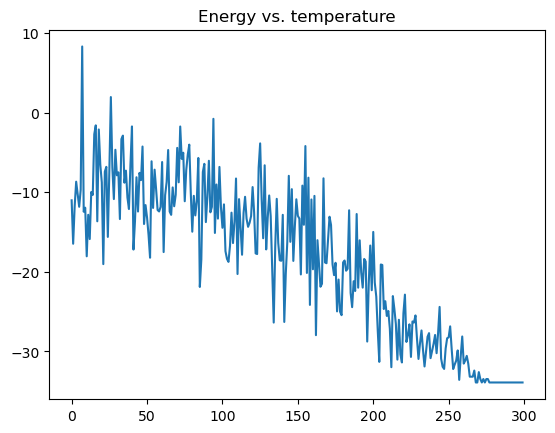

In [70]:
import numpy as np
from dataclasses import dataclass
from typing import Callable, Dict, Iterable, Optional, Tuple, Union
from numpy.random import Generator, PCG64

Array = np.ndarray

def geometric_schedule(T0: float, Tf: float, n_steps: int) -> Array:
    if n_steps < 2:
        return np.array([Tf], dtype=float)
    r = (Tf / T0) ** (1.0 / (n_steps - 1))
    return T0 * (r ** np.arange(n_steps))

def linear_schedule(T0: float, Tf: float, n_steps: int) -> Array:
    return np.linspace(T0, Tf, n_steps, dtype=float)

def log_schedule(T0: float, c: float, n_steps: int) -> Array:
    ks = np.arange(n_steps)
    return T0 / (1.0 + c * np.log1p(ks))

@dataclass
class SAConfig:
    steps: int = 200
    sweeps_per_step: int = 10
    schedule: str = "geometric"           # "geometric" | "linear" | "log" | "custom"
    T0: float = 2.5
    Tf: float = 0.01
    log_c: float = 0.5
    custom_schedule_fn: Optional[Callable[[int], Array]] = None
    rng: Optional[Generator] = None
    record_trajectory: bool = False
    early_stop_patience: Optional[int] = None  # temperature steps without improvement

class SimulatedAnnealingOptimizer:
    """
    Generic SA optimizer for Ising-like models exposing:
      - n (int), energy(s: Iterable[int]) -> float, flip_energy_delta(s, i) -> float, rng (Generator)
    """

    def __init__(self, model, config: Optional[SAConfig] = None):
        self.model = model
        self.config = config or SAConfig()
        self.rng = self.config.rng or getattr(model, "rng", Generator(PCG64()))

    def _temperatures(self, steps: int) -> Array:
        c = self.config
        if c.schedule == "custom":
            if c.custom_schedule_fn is None:
                raise ValueError("custom_schedule_fn must be provided when schedule='custom'.")
            T = np.asarray(c.custom_schedule_fn(steps), dtype=float)
            if T.shape != (steps,):
                raise ValueError(f"custom_schedule_fn must return shape ({steps},)")
            return T
        if c.schedule == "geometric":
            return geometric_schedule(c.T0, c.Tf, steps)
        if c.schedule == "linear":
            return linear_schedule(c.T0, c.Tf, steps)
        if c.schedule == "log":
            return log_schedule(c.T0, c.log_c, steps)
        raise ValueError("schedule must be 'geometric', 'linear', 'log', or 'custom'.")

    def optimize(
        self,
        s0: Optional[Iterable[int]] = None,
        callback: Optional[Callable[[int, float, Array], None]] = None,
    ) -> Tuple[Array, float, Dict[str, Array]]:
        """
        Runs SA and returns (s_best, E_best, info).
        info contains "T" and optionally "E", "E_best_so_far".
        """
        m, c, rng = self.model, self.config, self.rng
        n = m.n
        s = np.array(s0, dtype=int) if s0 is not None else rng.choice(np.array([-1, 1], dtype=int), size=n)

        T_arr = self._temperatures(c.steps)
        E = m.energy(s)
        s_best, E_best = s.copy(), E

        if c.record_trajectory:
            Es = np.empty(c.steps, dtype=float)
            Ebs = np.empty(c.steps, dtype=float)

        no_imp = 0
        for k, T in enumerate(T_arr):
            beta = 1.0 / T if T > 0.0 else np.inf
            for _ in range(c.sweeps_per_step * n):
                i = rng.integers(0, n)
                dE = m.flip_energy_delta(s, i)
                if dE <= 0.0 or rng.random() < np.exp(-beta * dE):
                    s[i] = -s[i]
                    E += dE
                    if E < E_best:
                        E_best = E
                        s_best = s.copy()
                        no_imp = 0
            if c.record_trajectory:
                Es[k] = E
                Ebs[k] = E_best
            if callback is not None:
                callback(k, E, s)
            if c.early_stop_patience is not None:
                no_imp += 1
                if no_imp >= c.early_stop_patience:
                    # truncate recorded arrays if needed
                    if c.record_trajectory:
                        Es = Es[: k + 1]
                        Ebs = Ebs[: k + 1]
                        T_arr = T_arr[: k + 1]
                    break

        info: Dict[str, Array] = {"T": T_arr}
        if c.record_trajectory:
            info["E"] = Es
            info["E_best_so_far"] = Ebs
        return s_best, float(E_best), info


cfg = SAConfig(steps=300, sweeps_per_step=5, schedule="linear", T0=3.0, Tf=0.01,
                record_trajectory=True, early_stop_patience=None)
opt = SimulatedAnnealingOptimizer(sk, cfg)
s_star, E_star, info = opt.optimize()
print("Best energy:", E_star)

plt.figure()
plt.plot(info["E"])
plt.title("Energy vs. temperature")
plt.show()

## Annealing schedules and learning rate schedules

Above, we lower the temperature $T$ linearly. This is a common choice, but not the only one. We can also use a **geometric** schedule, where $T$ is multiplied by a factor $r$ at each step:

$$
T_{i+1} = r T_i
$$

We can also use a **logarithmic** schedule, where $T$ is divided by a factor $c$ at each step:

$$
T_{i+1} = T_i / (1 + c \log(i))
$$

We will try implementing these alteranate schedules, to see how they perform.


# How well did we do? The analytic prediction in the many spin case

We can compare the results of our simulated annealing algorithm to the analytic prediction for the ground state energy of the Sherrington-Kirkpatrick model. In the $N\to\infty$ limit, [various]((https://www.google.com/books/edition/_/DwY8DQAAQBAJ)) analytic [techniques](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.65.046137) based on the replica method estimate a constant energy density of approximately $-0.76321$.

$$
    \mathbb{E}[E_0] = -0.76321 \,N
$$

where $N$ is the number of spins.

https://intlpress.com/site/pub/files/_fulltext/journals/cdm/2014/2014/0001/CDM-2014-2014-0001-a004.pdf

We can compare the results of our simulated annealing algorithm to the analytic prediction.

In [65]:
def analytic_ground_state_energy(n: int) -> float:
    """Returns the approximate ground state energy density in the many spin limit"""
    return -n * 0.76321

analytic_ground_state_energy(sk.n)


-76.32100000000001

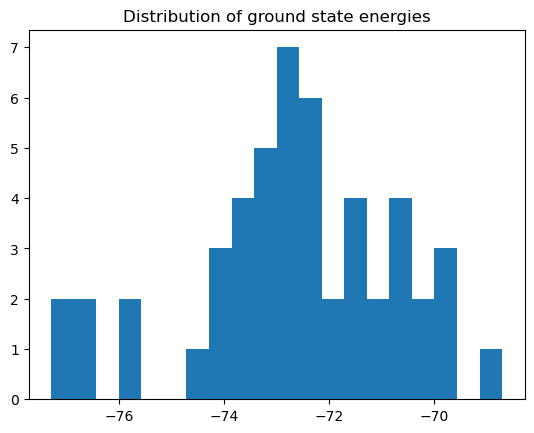

Across replicates, the median ground state energy is -72.76938783655172


In [66]:
all_Es = []
for seed in range(50):
    sk = SherringtonKirkpatrickSpinGlass(n=100, scale="1/sqrt(n)", random_state=seed)
    cfg = SAConfig(steps=300, sweeps_per_step=5, schedule="geometric", T0=3.0, Tf=0.01,
                record_trajectory=True, early_stop_patience=None)
    opt = SimulatedAnnealingOptimizer(sk, cfg)
    s_star, E_star, info = opt.optimize()
    all_Es.append(E_star)

plt.figure()
plt.hist(all_Es, bins=20)
plt.title("Distribution of ground state energies")
plt.show()


print(f"Across replicates, the median ground state energy is {np.median(all_Es)}")


We expect that the gap between the predicted and actual ground state arises due to three effects:

1. The finite size of the system.
2. The finite temperature of the system.
3. Randomness in the couplings.
4. Insufficient optimization.

We can try varying $N$ and see how the gap changes, in order to understand finite size effects. [Prior](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10005) [numerical](https://link.springer.com/article/10.1140/epjb/e2005-00280-6) [studies](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.76.184412) estimate the the gap between the finite and infinite size ground states decreases as $\sim N^{-0.67}$.

However, we can also try improving our optimizer, to see if a better optimizer can close the gap.









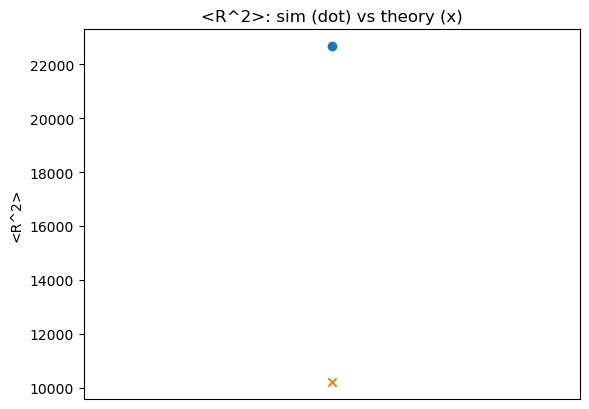

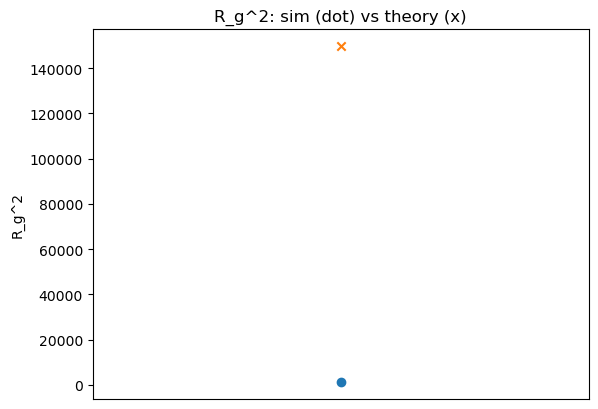

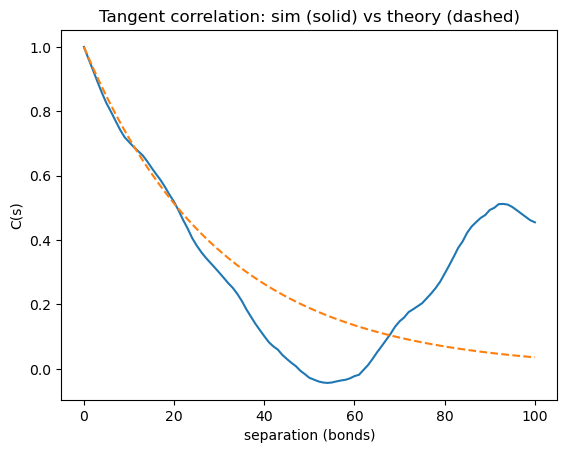

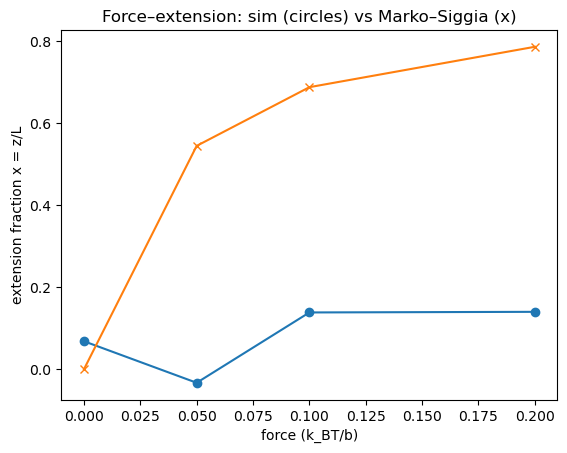

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- WLC Monte Carlo + Analytics ----------
def rand_unit_vec(rng):
    z = rng.uniform(-1.0, 1.0)
    phi = rng.uniform(0.0, 2.0*np.pi)
    r = np.sqrt(max(0.0, 1.0 - z*z))
    return np.array([r*np.cos(phi), r*np.sin(phi), z], dtype=float)

def rotate_vec(v, axis, angle):
    a = axis / np.linalg.norm(axis)
    c, s = np.cos(angle), np.sin(angle)
    return v*c + np.cross(a, v)*s + a*(np.dot(a, v))*(1.0 - c)

class WormlikeChainMC:
    def __init__(self, N=200, b=1.0, kappa=20.0, beta=1.0, seed=None):
        self.N, self.b = int(N), float(b)
        self.kappa, self.beta = float(kappa), float(beta)
        self.rng = np.random.default_rng(seed)
        self.t = np.tile(np.array([1.0,0.0,0.0]), (self.N,1))
        self.t += 0.05 * self.rng.normal(size=self.t.shape)
        self.t /= np.linalg.norm(self.t, axis=1, keepdims=True)

    def positions(self):
        r = np.zeros((self.N+1, 3), dtype=float)
        np.cumsum(self.b * self.t, axis=0, out=r[1:])
        return r

    def energy(self):
        dots = (self.t[:-1] * self.t[1:]).sum(axis=1)
        return self.kappa * np.sum(1.0 - dots)

    def _local_deltaE(self, i, t_new):
        dE = 0.0
        if i > 0:
            dE += self.kappa * ((1.0 - np.dot(t_new, self.t[i-1])) - (1.0 - np.dot(self.t[i], self.t[i-1])))
        if i < self.N-1:
            dE += self.kappa * ((1.0 - np.dot(t_new, self.t[i+1])) - (1.0 - np.dot(self.t[i], self.t[i+1])))
        return dE

    def sweep(self, step_size=0.25):
        acc = 0
        for _ in range(self.N):
            i = int(self.rng.integers(self.N))
            axis = rand_unit_vec(self.rng)
            angle = self.rng.normal(scale=step_size)
            t_new = rotate_vec(self.t[i], axis, angle)
            t_new /= np.linalg.norm(t_new)
            dE = self._local_deltaE(i, t_new)
            if dE <= 0.0 or self.rng.random() < np.exp(-self.beta * dE):
                self.t[i] = t_new
                acc += 1
        return {"acc": acc / self.N, "E": self.energy()}

# --- theory helpers ---
def wlc_lp_from_kappa_b(kappa, b): return float(kappa) * float(b)
def wlc_R2_theory(L, lp): L, lp = float(L), float(lp); return 2.0 * lp * L * (1.0 - (lp / L) * (1.0 - np.exp(-L / lp)))
def wlc_C_theory(s_idx, b, lp): return np.exp(-np.asarray(s_idx, dtype=float) * b / lp)

def wlc_Rg2_theory(L, lp, n_quad=1500):
    L, lp = float(L), float(lp)
    s = np.linspace(0.0, L, n_quad)
    ds = s[1] - s[0]
    diff = np.abs(s[:, None] - s[None, :])
    K = np.exp(-diff / lp)
    Kc = K.cumsum(axis=0).cumsum(axis=1) * (ds**2)
    def box(i, j): return Kc[i, j]
    tot = 0.0
    for i in range(n_quad):
        for j in range(i + 1):
            I = box(i, i) - box(j, i) - box(i, j) + box(j, j)
            tot += 2.0 * I
    return float((1.0 / (L * L)) * tot)

def marko_siggia_extension_fraction(f, L, lp):
    flp = float(f) * float(lp)
    x = min(0.99, max(0.0, flp / (1.0 + flp)))
    for _ in range(40):
        g = 0.25 * (1.0 - x)**-2 - 0.25 + x - flp
        dg = 0.5 * (1.0 - x)**-3 + 1.0
        step = g / dg
        x_new = x - step
        x = min(0.999999, max(0.0, x_new))
        if abs(step) < 1e-12: break
    return float(x)

# --- measurement helpers ---
def measure_R2(chain):
    R = chain.b * chain.t.sum(axis=0)
    return float(R @ R)

def measure_Rg2(chain):
    r = chain.positions()
    rc = r.mean(axis=0)
    d2 = ((r - rc) ** 2).sum(axis=1)
    return float(d2.mean())

def measure_C_of_s(chain, max_s=None):
    N = chain.N
    if max_s is None: max_s = N - 1
    s_vals = np.arange(0, max_s + 1, dtype=int)
    C = np.zeros_like(s_vals, dtype=float)
    for k, s in enumerate(s_vals):
        dots = (chain.t[: N - s] * chain.t[s:]).sum(axis=1)
        C[k] = float(np.mean(dots))
    return s_vals, C

def sweep_with_force(chain, step_size=0.25, force=0.0, axis=(0.0, 0.0, 1.0)):
    a = np.asarray(axis, dtype=float); a /= np.linalg.norm(a)
    acc = 0
    for _ in range(chain.N):
        i = int(chain.rng.integers(chain.N))
        axis_rand = rand_unit_vec(chain.rng)
        angle = chain.rng.normal(scale=step_size)
        t_new = rotate_vec(chain.t[i], axis_rand, angle); t_new /= np.linalg.norm(t_new)
        dE_bend = chain._local_deltaE(i, t_new)
        dE_force = -force * chain.b * (np.dot(t_new, a) - np.dot(chain.t[i], a))
        dE = dE_bend + dE_force
        if dE <= 0.0 or chain.rng.random() < np.exp(-chain.beta * dE):
            chain.t[i] = t_new; acc += 1
    return acc / chain.N

def test_suite(chain, n_eq=1500, n_meas=1500, step_size=0.25, forces=(0.0, 0.05, 0.1, 0.2)):
    L = chain.N * chain.b
    lp = wlc_lp_from_kappa_b(chain.kappa, chain.b)

    for _ in range(n_eq): chain.sweep(step_size=step_size)

    R2_vals = []
    for _ in range(n_meas):
        chain.sweep(step_size=step_size)
        R2_vals.append(measure_R2(chain))
    R2_sim = float(np.mean(R2_vals))
    R2_th = wlc_R2_theory(L, lp)

    Rg2_sim = measure_Rg2(chain)
    Rg2_th = wlc_Rg2_theory(L, lp)

    s_sim, C_sim = measure_C_of_s(chain, max_s=min(100, chain.N - 1))
    C_th = wlc_C_theory(s_sim, chain.b, lp)

    f_rows = []
    for f in forces:
        tmp = WormlikeChainMC(N=chain.N, b=chain.b, kappa=chain.kappa, beta=chain.beta, seed=1234)
        for _ in range(n_eq // 2): sweep_with_force(tmp, step_size=step_size, force=f)
        z_over_L = []
        for _ in range(max(5, n_meas // 20)):
            sweep_with_force(tmp, step_size=step_size, force=f)
            z = tmp.b * tmp.t[:, 2].sum()
            z_over_L.append(z / L)
        x_sim = float(np.mean(z_over_L))
        x_th = marko_siggia_extension_fraction(f, L, lp)
        f_rows.append((f, x_sim, x_th))

    return {
        "R2": {"sim": R2_sim, "theory": R2_th, "rel_err": (R2_sim - R2_th) / R2_th},
        "Rg2": {"sim": Rg2_sim, "theory": Rg2_th, "rel_err": (Rg2_sim - Rg2_th) / Rg2_th},
        "C": {"s": s_sim, "sim": C_sim, "theory": C_th},
        "F_ext": [{"f": f, "x_sim": xs, "x_MS": xt, "abs_err": xs - xt} for f, xs, xt in f_rows],
        "L": L, "lp": lp,
    }




# ---------- Run the test suite and plot comparisons ----------
mc = WormlikeChainMC(N=200, b=1.0, kappa=30.0, beta=1.0, seed=7)
res = test_suite(mc, n_eq=1200, n_meas=1200, step_size=0.22, forces=(0.0, 0.05, 0.1, 0.2))

# 1) <R^2> comparison
plt.figure()
plt.scatter([0], [res["R2"]["sim"]])
plt.scatter([0], [res["R2"]["theory"]], marker="x")
plt.xticks([])
plt.ylabel("<R^2>")
plt.title("<R^2>: sim (dot) vs theory (x)")
plt.show()

# 2) Rg^2 comparison
plt.figure()
plt.scatter([0], [res["Rg2"]["sim"]])
plt.scatter([0], [res["Rg2"]["theory"]], marker="x")
plt.xticks([])
plt.ylabel("R_g^2")
plt.title("R_g^2: sim (dot) vs theory (x)")
plt.show()

# 3) Tangent correlation curve
plt.figure()
s = res["C"]["s"]
plt.plot(s, res["C"]["sim"])
plt.plot(s, res["C"]["theory"], linestyle="--")
plt.xlabel("separation (bonds)")
plt.ylabel("C(s)")
plt.title("Tangent correlation: sim (solid) vs theory (dashed)")
plt.show()

# 4) Force–extension curve
plt.figure()
fs = [row["f"] for row in res["F_ext"]]
x_sim = [row["x_sim"] for row in res["F_ext"]]
x_th = [row["x_MS"] for row in res["F_ext"]]
plt.plot(fs, x_sim, marker="o")
plt.plot(fs, x_th, marker="x")
plt.xlabel("force (k_BT/b)")
plt.ylabel("extension fraction x = z/L")
plt.title("Force–extension: sim (circles) vs Marko–Siggia (x)")
plt.show()

# Print concise numeric summary
summary = {
    "R2_rel_err": res["R2"]["rel_err"],
    "Rg2_rel_err": res["Rg2"]["rel_err"],
    "Fext_abs_err": {row["f"]: row["abs_err"] for row in res["F_ext"]},
    "L": res["L"],
    "lp": res["lp"],
}
# summary


In [5]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

%matplotlib inline


### Two-spin Online Convex Optimization via convexification (correlation control)

Our optimization variables are discrete, and correspond to the spins of a 2-spin Ising model.

$$
\begin{align*}
    \mathcal{L} & = - \sum_{i=1}^N \sum_{j=1}^N J_{ij} s_i s_j \\
    \mathcal{L} & = - J_{12} s_1 s_2
\end{align*}
$$

We can globally minimize the loss simply by *combinatorial optimization*. We try all $2 \times 2 = 4$ possible values of the spins, and pick the one that minimizes the loss. However, while this is tractable for the two spin case, it is expensive (problem size scales in $N$ and likely non-convex. What if we instead wanted to pose this as an online learning problem suitable for iterative optimization? 

We need to define a surrogate loss that is convex and differentiable, and that we can optimize. For this case, we can use correlation:
$$
  \hat{\mathcal{L}} = s_1 s_2
$$

### Establishing bounds on the surrogate loss

At each round indexed by $t$, we propose a spin configuration $s_{1t}$, $s_{2t}$ we compute a surrogate loss $\hat{\mathcal{L}}$. We want to establish bounds on the surrogate loss, assuming that we made the worst possible choice for $s_{1t}$, $s_{2t}$.

$$
\begin{align*}
  \hat{\mathcal{L}} & = s_{1t} s_{2t} \\
  \hat{\mathcal{L}} & = s_{1t} s_{2t}
\end{align*}
$$


In [1]:
import numpy as np

def sample_spins_with_correlation(c, rng):
    """
    Given target correlation c in [-1,1], sample (s1,s2) in {±1}^2 with E[s1*s2]=c.
    """
    assert -1.0 <= c <= 1.0
    s1 = rng.choice([-1, 1])
    if rng.random() < (1 + c) / 2:
        s2 = s1
    else:
        s2 = -s1
    return s1, s2

def run_2spin_ogd(T=200, eta=None, j_seq=None, adversary="adaptive", seed=0):
    """
    Online gradient descent on the convex surrogate c_t ∈ [-1,1] for two spins.
    Loss per round: ℓ_t = - j_t * (s1_t*s2_t).
    Update on expected loss: c_{t+1} = Proj_{[-1,1]}(c_t + η * j_t).

    adversary:
      - "adaptive": chooses j_t = -sign(c_t) (worst for the current c_t), with tie broken uniformly
      - "given":    uses provided j_seq (length T), values in [-1,1]
      - "random":   j_t ~ Unif({-1, +1})
    """
    rng = np.random.default_rng(seed)
    if eta is None:
        eta = 2.0 / np.sqrt(T)  # OGD step ~ D/(G*sqrt(T)) with D=2, G≤1
    c = 0.0  # start at 0 correlation
    c_hist = []
    j_hist = []
    loss_realized = []
    loss_expected = []

    for t in range(T):
        # Adversary picks j_t after seeing c_t
        if adversary == "adaptive":
            s = np.sign(c)
            if s == 0:
                j_t = rng.choice([-1.0, 1.0])
            else:
                j_t = -float(s)  # linear loss -j*c is maximized by j = -sign(c)
        elif adversary == "given":
            if j_seq is None or len(j_seq) != T:
                raise ValueError("Provide j_seq of length T for adversary='given'.")
            j_t = float(j_seq[t])
        elif adversary == "random":
            j_t = rng.choice([-1.0, 1.0])
        else:
            raise ValueError("adversary must be in {'adaptive','given','random'}")
        j_hist.append(j_t)

        # Play discrete spins realizing correlation c
        s1, s2 = sample_spins_with_correlation(c, rng)
        prod = s1 * s2

        # Losses
        loss_t_real = - j_t * prod
        loss_t_exp  = - j_t * c
        loss_realized.append(loss_t_real)
        loss_expected.append(loss_t_exp)

        # OGD update on the convex surrogate (expected loss)
        c = np.clip(c + eta * j_t, -1.0, 1.0)
        c_hist.append(c)

    # Best fixed comparator over c in {±1} (equivalently, best fixed spin product)
    S = float(np.sum(j_hist))
    c_star = 1.0 if S < 0 else -1.0 if S > 0 else 1.0  # minimizes -S*c
    comp_expected = - c_star * S

    out = {
        "c_hist": np.array(c_hist),
        "j_hist": np.array(j_hist),
        "loss_realized": np.array(loss_realized),
        "loss_expected": np.array(loss_expected),
        "cum_loss_realized": float(np.sum(loss_realized)),
        "cum_loss_expected": float(np.sum(loss_expected)),
        "cum_loss_comp_expected": float(comp_expected),
        "regret_expected": float(np.sum(loss_expected) - comp_expected),
        "params": {"T": T, "eta": eta, "adversary": adversary, "seed": seed}
    }
    return out


res2 = run_2spin_ogd(T=200, adversary="adaptive", seed=0)
print("2-spin: cum expected loss =", res2["cum_loss_expected"],
        " comparator exp. loss =", res2["cum_loss_comp_expected"],
        " regret_exp =", res2["regret_expected"])


2-spin: cum expected loss = 14.142135623730947  comparator exp. loss = -0.0  regret_exp = 14.142135623730947


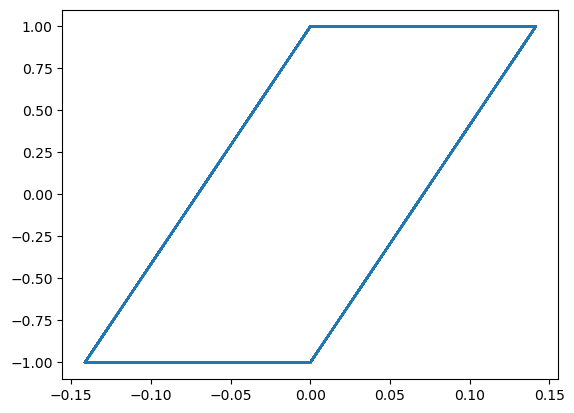

In [8]:
plt.plot(res2["c_hist"], res2["j_hist"])

In [9]:



# ============================================================
# 2) n-spin Ising with adversarial J_t, convex relaxation
#    (elliptope surrogate + Gaussian sign rounding)
#    NOTE: uses an approximate projection to the elliptope.
# ============================================================

def project_psd_with_unit_diag(C, eps=1e-10):
    """
    Approximate projection onto {C ⪰ 0, diag(C)=1}.
    Steps: symmetrize → set diag to 1 → PSD projection (clip neg eigvals) → reset diag to 1.
    This is not the exact elliptope projection (which is an SDP), but works well in practice.
    """
    C = 0.5 * (C + C.T)
    np.fill_diagonal(C, 1.0)
    # PSD projection
    w, V = np.linalg.eigh(C)
    w_clipped = np.clip(w, a_min=0.0, a_max=None)
    C_psd = (V * w_clipped) @ V.T
    C_psd = 0.5 * (C_psd + C_psd.T)
    # Enforce unit diagonal again (light renormalization)
    d = np.sqrt(np.maximum(np.diag(C_psd), eps))
    D_inv = np.diag(1.0 / d)
    C_norm = D_inv @ C_psd @ D_inv
    C_norm = 0.5 * (C_norm + C_norm.T)
    np.fill_diagonal(C_norm, 1.0)
    return C_norm

def gaussian_sign_rounding(C, rng):
    """
    Sample s ∈ {±1}^n via Gaussian sign rounding with covariance C.
    """
    n = C.shape[0]
    # Ensure strictly PD covariance for sampling
    jitter = 1e-8
    G = rng.multivariate_normal(mean=np.zeros(n), cov=C + jitter * np.eye(n))
    s = np.sign(G)
    s[s == 0] = 1
    return s.astype(int)

def adversary_against_spins(s):
    """
    Worst-case (entrywise-bounded) J_t for current spin s:
      J_ij = - s_i s_j for i ≠ j,  J_ii = 0.
    This maximizes loss -s^T J s subject to |J_ij| ≤ 1 and zero diagonal.
    """
    n = len(s)
    J = -np.outer(s, s)
    np.fill_diagonal(J, 0.0)
    return J

def run_nspin_online_relaxation(n=20, T=200, eta=None, J_seq=None, adversary="adaptive", seed=1):
    """
    Online linear optimization over the elliptope surrogate C_t, with Gaussian sign rounding to play spins.
    Loss per round: ℓ_t(s_t) = - s_t^T J_t s_t. Surrogate loss: L_t(C_t) = -⟨J_t, C_t⟩.

    Update: C_{t+1} ≈ Proj_{elliptope}( C_t + η * J_t )
    (gradient of L_t wrt C is -J_t; gradient DEScent step is C - η*(-J_t) = C + η J_t)

    adversary:
      - "adaptive": picks J_t = adversary_against_spins(s_t)
      - "given":    uses provided list of J_t (len T), symmetric with zero diagonal
      - "random":   i.i.d. J_t with entries in {-1, +1} off-diagonal and 0 on diagonal
    """
    rng = np.random.default_rng(seed)
    if eta is None:
        eta = 1.0 / np.sqrt(T)  # heuristic O(1/sqrt(T)) step
    C = np.eye(n)
    C_hist = []
    loss_realized = []
    loss_surrogate = []
    Js = []

    for t in range(T):
        # Play spins via rounding of current correlation C
        s = gaussian_sign_rounding(C, rng)

        # Adversary chooses J_t
        if adversary == "adaptive":
            J_t = adversary_against_spins(s)
        elif adversary == "given":
            if J_seq is None or len(J_seq) != T:
                raise ValueError("Provide J_seq (len T, symmetric, zero diagonal) for adversary='given'.")
            J_t = 0.5 * (J_seq[t] + J_seq[t].T)
            np.fill_diagonal(J_t, 0.0)
        elif adversary == "random":
            J_t = rng.choice([-1.0, 1.0], size=(n, n))
            J_t = 0.5 * (J_t + J_t.T)
            np.fill_diagonal(J_t, 0.0)
        else:
            raise ValueError("adversary must be in {'adaptive','given','random'}")
        Js.append(J_t)

        # Realized discrete loss
        loss_t = - float(s.T @ J_t @ s)
        loss_realized.append(loss_t)

        # Surrogate (expected) loss under C_t: -⟨J_t, C_t⟩
        loss_sur = - float(np.sum(J_t * C))
        loss_surrogate.append(loss_sur)

        # Online update on the surrogate
        C = C + eta * J_t
        C = project_psd_with_unit_diag(C)  # approximate projection
        C_hist.append(C.copy())

    # Comparator (best fixed spin in hindsight) for reporting:
    # NP-hard to compute exactly; we report the surrogate comparator instead.
    comp_surrogate = -float(np.sum(np.sum(Js, axis=0) * np.eye(n)))  # = 0 since diag=0; kept for clarity
    # Better: best fixed C in the surrogate is not trivial; we omit exact value and report totals.

    out = {
        "C_hist": C_hist,
        "loss_realized": np.array(loss_realized),
        "loss_surrogate": np.array(loss_surrogate),
        "cum_loss_realized": float(np.sum(loss_realized)),
        "cum_loss_surrogate": float(np.sum(loss_surrogate)),
        "params": {"n": n, "T": T, "eta": eta, "adversary": adversary, "seed": seed}
    }
    return out




# Example 2: n-spin relaxation with adaptive adversary
resN = run_nspin_online_relaxation(n=20, T=200, adversary="adaptive", seed=1)
print("n-spin: cum realized loss =", resN["cum_loss_realized"],
        " cum surrogate loss =", resN["cum_loss_surrogate"])

n-spin: cum realized loss = 76000.0  cum surrogate loss = 886.0047399131901


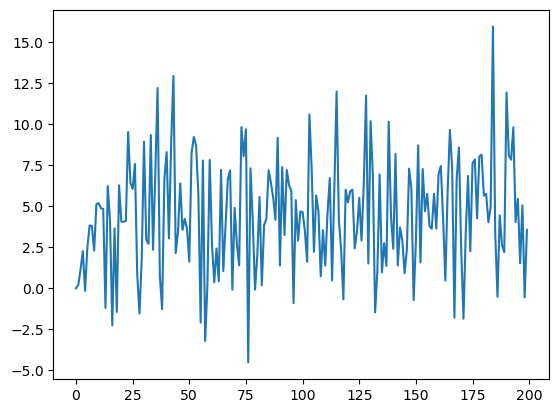

In [12]:
plt.plot(resN["loss_surrogate"])